In [1]:
import pandas as pd
import numpy as np

In [2]:
from dateutil import parser
from datetime import datetime
import sys, os
import re
import optuna
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, RepeatedKFold, KFold, ShuffleSplit
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
optuna.logging.set_verbosity(optuna.logging.WARNING)
from Stacking_model import BoostedHybrid

In [3]:
#9. read resources 
data = pd.read_csv('data.csv',
                  parse_dates=['date'],
                  infer_datetime_format=True,
                  index_col = 0)

In [4]:
#del outliers
data = data.loc[data.outliers != -1]

In [5]:
#it's not a category feature
data.onpromotion = data.onpromotion.astype('float64')

In [6]:
#let's create skus
data['sku'] = data.store_nbr.astype('str') + '-' + data.family

In [7]:
data['cumsum'] = data.groupby('sku')['sales_1'].expanding(1).sum().reset_index().set_index('date').sort_values(['date', 'sku'])['sales_1']

In [8]:
#for Kaggle
final = data.loc[data.index.max()]
#for comparing approaches
holdout = data.loc[(data.index.max()-pd.Timedelta('30d')) :\
                       (data.index.max()-pd.Timedelta('1d'))]

#### `Exclude skus with zero and nearly zero consumption`

In [9]:
#let's find skus without any consumption and exclude them from the dataset
dg = data.groupby('sku')['sales_1'].sum()
sku_0 = dg.loc[dg == 0].index

In [10]:
len(sku_0)

70

In [11]:
dg2 = data.groupby(['sku', 'year'])['sales_1'].sum().reset_index()

In [12]:
dg2['cs'] = dg2.groupby(['sku'])['sales_1'].expanding(1).sum().values

In [13]:
#sksu with zero consumption in 2017
sku_1 = dg2.loc[(dg2.year == 2017) &\
            (dg2.sales_1 == 0), 'sku'].unique()

In [14]:
#skus with zero consumption in 2017 and nonzero in previous periods
strange_skus = np.setdiff1d(sku_1, sku_0)

<AxesSubplot: xlabel='date'>

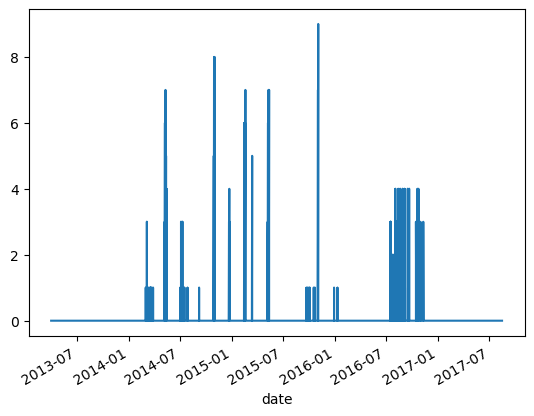

In [15]:
data.loc[data.sku.isin(strange_skus), 'sales_1'].plot()

##### `It's better to delete these skus also`

In [16]:
data = data.loc[~data.sku.isin(sku_1)]

In [17]:
#sksu with zero consumption before 2017 and nonzero in 2017
sku_2 = dg2.loc[(dg2.year == 2017) &\
            (dg2.sales_1 >0) &\
                (dg2.cs == dg2.sales_1), 'sku'].unique()

In [18]:
len(sku_2)

32

##### `It looks like 52 store opened in 2017`

<AxesSubplot: xlabel='date'>

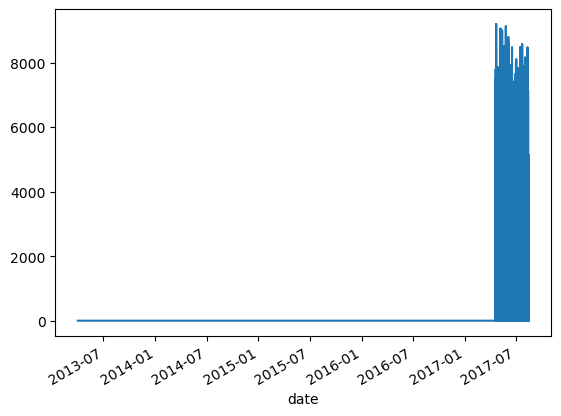

In [19]:
#sales for 52 store
data.loc[data.store_nbr == 52, 'sales_1'].plot()

In [20]:
#sksu with zero consumption before 2016 and nonzero in 2016
sku_3 = dg2.loc[(dg2.year == 2016) &\
            (dg2.sales_1 > 0) &\
                (dg2.cs == dg2.sales_1), 'sku'].unique()

In [21]:
len(sku_3)

43

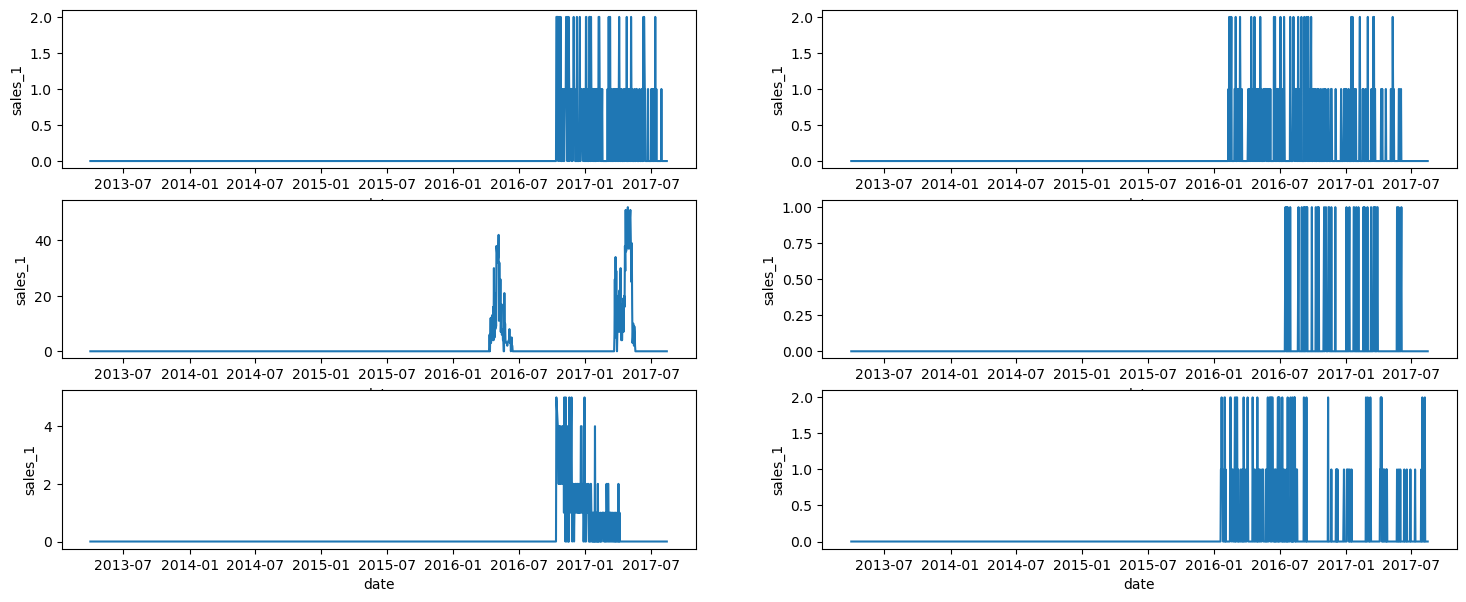

In [22]:
fig, axes = plt.subplots(3, 2, figsize = (18,7))
for n in range(6):
    sns.lineplot(data = data.loc[data.sku == sku_3[n], 'sales_1'], ax=axes[n//2][n%2])

##### `let's handle all such cases`

In [23]:
data = data.loc[~(data['cumsum'] == 0)]

In [24]:
y_cols = [x for x in data.columns if x.startswith('sales')]
x_cols = [x for x in data.columns if x not in y_cols]

In [25]:
#test split
test = data.loc[(data.index<holdout.index.min()) &\
                   (data.index >= '2017-06-01')]
train = data.loc[data.index < test.index.min()]

In [26]:
train.dropna(inplace=True)

### Feature analysis

In [27]:
train.loc[:, x_cols].columns

Index(['store_nbr', 'family', 'onpromotion', 'day', 'week', 'month', 'year',
       'trend', 's(1,7)', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)',
       's(7,7)', 'sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)',
       'cos(2,freq=A-DEC)', 'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)',
       'cos(2,freq=M)', 'salary', 'outliers', 'y_lag_1', 'y_lag_2', 'y_lag_3',
       'MA_2', 'MA_3', 'MA_4', 'MA_5', 'MA_6', 'MA_30', 'MA_60', 'MA_90',
       'city', 'state', 'type', 'cluster', 'tr_10', 'tr_20', 'tr_30', 'oil_10',
       'oil_20', 'oil_30', 'national', 'local', 'regional', 'holiday', 'sku',
       'cumsum'],
      dtype='object')

In [28]:
base_features = ['store_nbr', 'family', 'onpromotion', 'day', 'week', 'month', 'year',
       'trend', 's(1,7)', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)',
       's(7,7)', 'sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)',
       'cos(2,freq=A-DEC)', 'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)',
       'cos(2,freq=M)', 'salary', 'outliers', 'y_lag_1', 'y_lag_2', 'y_lag_3',
       'MA_2', 'MA_3', 'MA_4', 'MA_5', 'MA_6', 'MA_30', 'MA_60', 'MA_90',
       'city', 'state', 'type', 'cluster', 'tr_10', 'tr_20', 'tr_30', 'oil_10',
       'oil_20', 'oil_30', 'national', 'local', 'regional', 'holiday', 'sku']

In [29]:
# size_of_test = test_data.loc[test_data.month == parameters['test_months'][-1]].shape[0]

### MI score

In [30]:
from ts_tools import make_mi_scores, plot_mi_scores

In [31]:
X = train.loc['2017':, base_features].copy().reset_index(drop = True)
y = train.loc['2017':, 'sales_1'].copy().reset_index(drop = True)

# Label encoding for categoricals
for colname in X.select_dtypes(["object", "int64"]):
    X[colname], _ = X[colname].factorize()

In [32]:
discrete_features = np.where(X.dtypes == int)[0]

In [33]:
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores  # show a few features with their MI scores

sku                  1.823194e+00
MA_30                1.649268e+00
MA_60                1.629484e+00
MA_90                1.623267e+00
MA_6                 1.612949e+00
MA_5                 1.584188e+00
MA_4                 1.560612e+00
MA_3                 1.550586e+00
MA_2                 1.531102e+00
y_lag_1              1.487205e+00
y_lag_2              1.361877e+00
y_lag_3              1.314893e+00
family               1.220317e+00
onpromotion          5.384319e-01
store_nbr            1.301880e-01
cluster              8.947462e-02
tr_20                7.023094e-02
tr_30                6.782078e-02
tr_10                6.505304e-02
type                 6.004511e-02
city                 5.524119e-02
state                4.436662e-02
trend                1.454824e-02
sin(1,freq=A-DEC)    1.412456e-02
week                 1.280338e-02
sin(2,freq=A-DEC)    1.232960e-02
oil_20               1.227534e-02
cos(2,freq=A-DEC)    1.223954e-02
oil_10               1.223570e-02
oil_30        

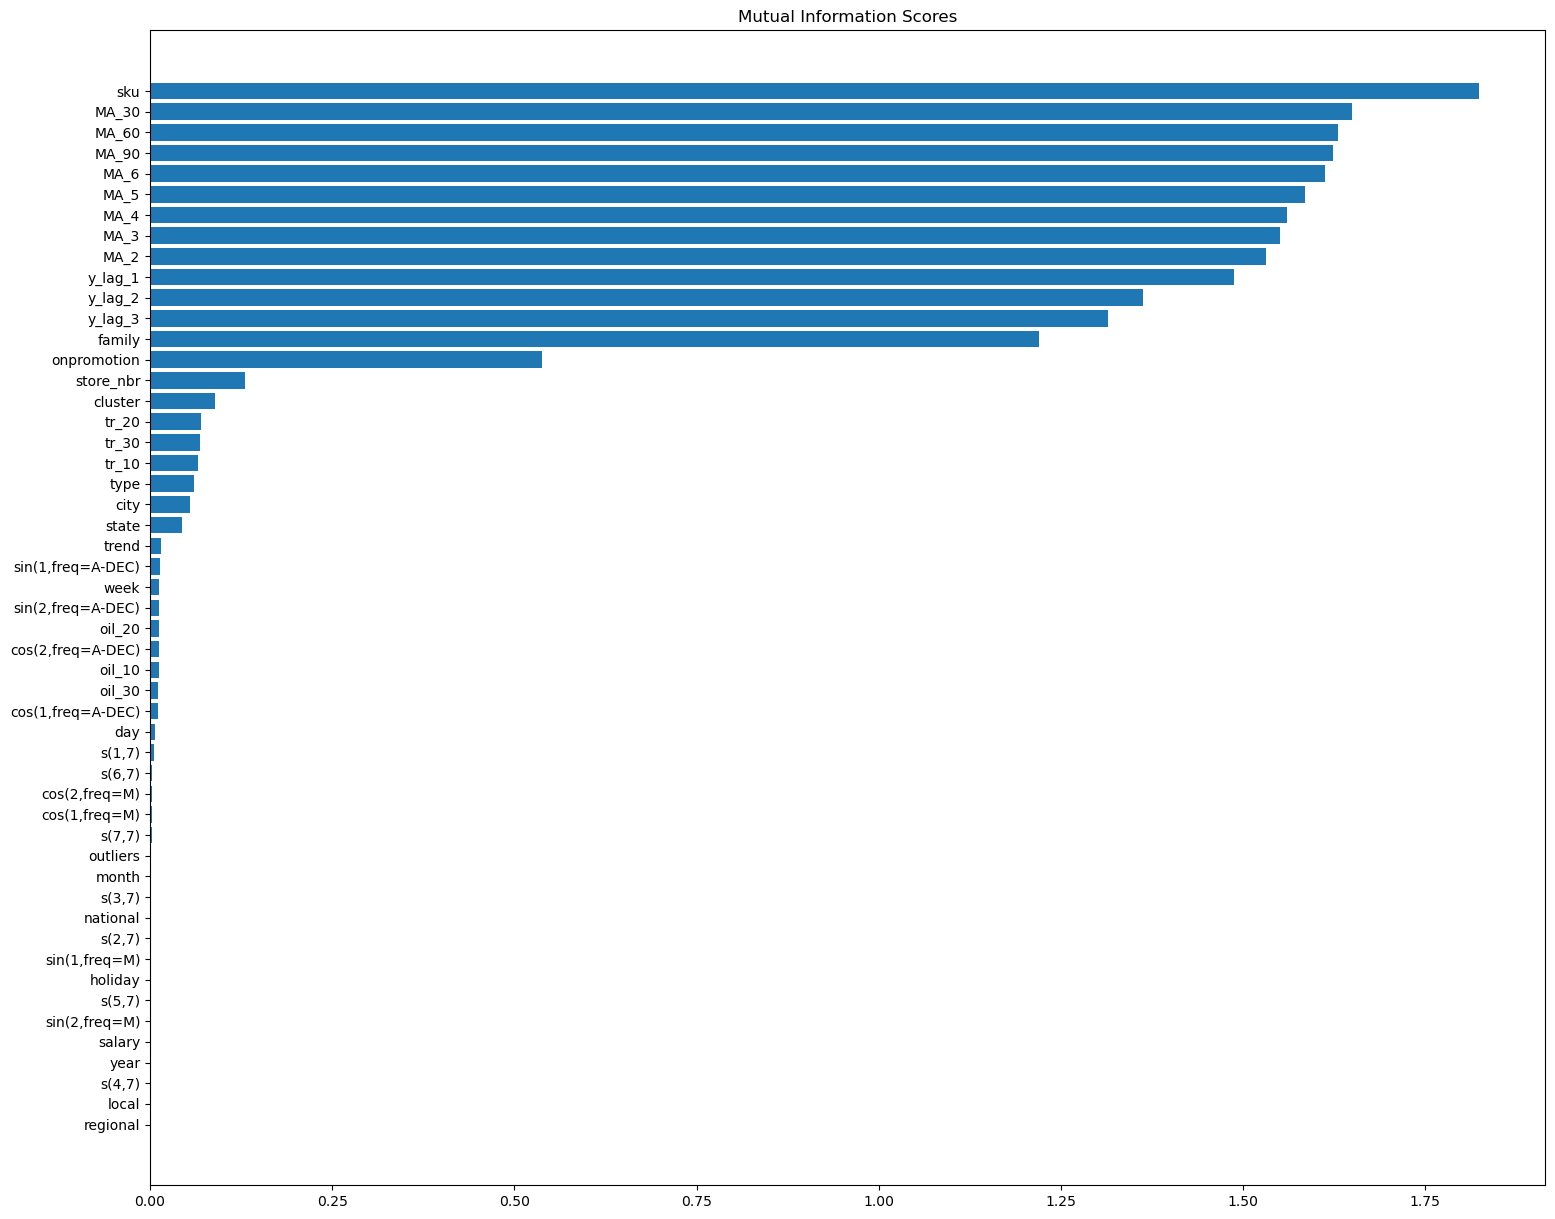

In [34]:
plt.figure(dpi=100, figsize=(18, 15))
plot_mi_scores(mi_scores)

### Pairplot

In [35]:
features_1 = ['onpromotion', 'MA_6', 'y_lag_3']

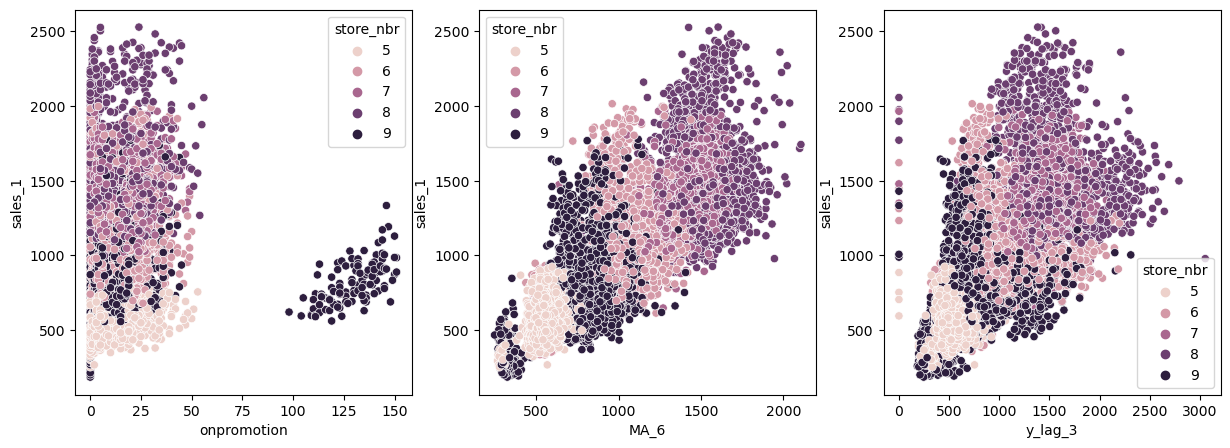

In [36]:
rows = int(len(features_1)//4+1*(len(features_1)%4 != 0))
plt.figure(figsize = (20,rows*5))
for n, _ in enumerate(features_1):
    ax = plt.subplot(rows, 4, n+1)
    sns.scatterplot(data = data.loc[(data.family == 'DAIRY') &\
                                       (data.store_nbr.isin(range(5,10)))], x = _, y = 'sales_1', ax = ax, hue = 'store_nbr')
    # try:
    #     # sns.kdeplot(data = train_data, x = _, ax = ax, shade = True)
    # except:
    #     continue
plt.show()

## Simplest approach

In [43]:
params = {
          'iterations': 10000,
          'depth': 10,
          'l2_leaf_reg': 3.0,
          'task_type': 'CPU',
          'verbose': 200,
          'border_count': 254,
          'random_strength': 1,
          'bootstrap_type': 'Bernoulli',
          'subsample': 0.6,
          'cat_features': discrete_features,
          'thread_count': -1,
          'has_time': True
    }

In [44]:
mask_holdout = holdout.sku.isin(sku_1)
mask_final = final.sku.isin(sku_1)

In [45]:
from tqdm.notebook import trange, tqdm

In [46]:
for seed in trange(len(y_cols)):
    cat = CatBoostRegressor(**params, random_state = seed+34)
    cat.fit(train.loc['2016':, x_cols], train.loc['2016':, y_cols[seed]],
           eval_set=(test.loc[test.loc[:, y_cols[seed]].notna(), x_cols],
                     test.loc[test.loc[:, y_cols[seed]].notna(), y_cols[seed]]),
            early_stopping_rounds=500,
            use_best_model=True)
    holdout[f'y_{seed+1}'] = 0
    holdout.loc[~mask_holdout, f'y_{seed+1}'] = cat.predict(holdout.loc[~mask_holdout, x_cols])
    holdout[f'y_{seed+1}'] = holdout[f'y_{seed+1}'].clip(0.0)
    
    final[f'y_{seed+1}'] = 0
    final.loc[~mask_final, f'y_{seed+1}'] = cat.predict(final.loc[~mask_final, x_cols])
    final[f'y_{seed+1}'] = final[f'y_{seed+1}'].clip(0.0)

  0%|          | 0/16 [00:00<?, ?it/s]

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1286.3709689	test: 1339.9722897	best: 1339.9722897 (0)	total: 777ms	remaining: 2h 9m 33s
200:	learn: 207.8967338	test: 230.4878889	best: 230.4878889 (200)	total: 1m 57s	remaining: 1h 35m 18s
400:	learn: 180.4078838	test: 215.3957150	best: 215.3957150 (400)	total: 4m	remaining: 1h 35m 48s
600:	learn: 164.4753955	test: 208.7735671	best: 208.7293951 (598)	total: 6m 4s	remaining: 1h 35m 3s
800:	learn: 153.1857965	test: 205.0004216	best: 205.0004216 (800)	total: 8m 11s	remaining: 1h 34m 2s
1000:	learn: 144.2876352	test: 202.3046617	best: 202.2665059 (997)	total: 10m 23s	remaining: 1h 33m 22s
1200:	learn: 137.0673603	test: 200.0391329	best: 200.0391329 (1200)	total: 12m 38s	remaining: 1h 32m 34s
1400:	learn: 131.5027387	test: 199.1708256	best: 199.1690615 (1399)	total: 14m 54s	remaining: 1h 31m 29s
1600:	learn: 126.4938315	test: 197.8202745	best: 197.8202745 (1600)	total: 17m 10s	remaining: 1h 30m 6s
1800:	learn: 122.1790673	test: 197.1818680	best: 197.1818680 (1800)	total: 19m 28s

In [47]:
results = pd.DataFrame(columns=range(1,17))
for n in range(len(y_cols)):
    mask2 = holdout.loc[:, y_cols[n]].notna()
    results.loc[1, n+1] = mean_absolute_error(
            holdout.loc[mask2, y_cols[n]],
            holdout.loc[mask2, f'y_{n+1}'])

In [48]:
results

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,60.576277,76.720337,76.394389,83.675293,82.66865,76.894471,71.916908,81.668975,90.035106,92.315839,87.196205,82.053017,83.171316,79.625042,88.0195,88.821349


#### Example for highrunners

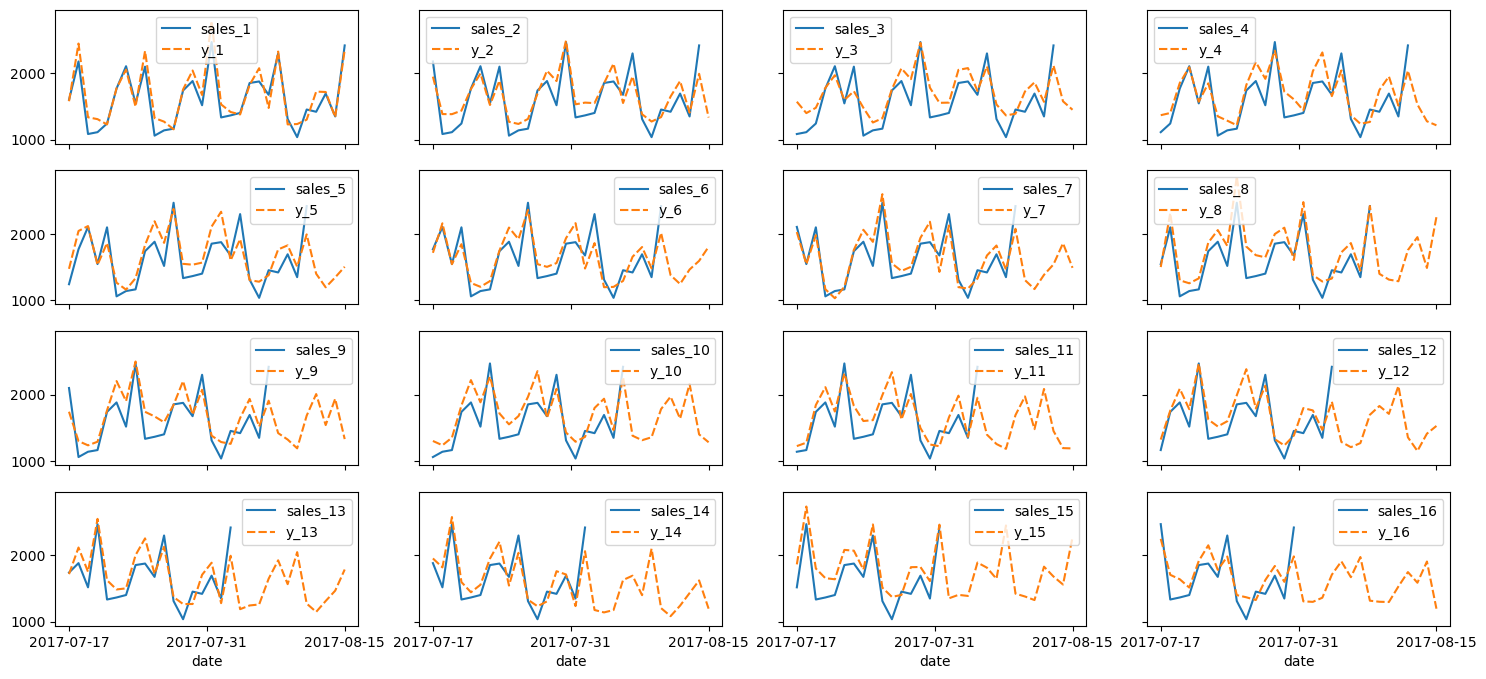

In [49]:
fig, axes = plt.subplots(4,4, figsize = (18,8), sharex=True, sharey=True)
for n in range(16):
    sns.lineplot(holdout.loc[(holdout.store_nbr == 9) &\
             (holdout.family == 'PRODUCE'), [f'sales_{n+1}', f'y_{n+1}']], ax = axes[n//4][n%4])
plt.xticks(pd.date_range(holdout.index[0], holdout.index[-1], 3))
plt.show()

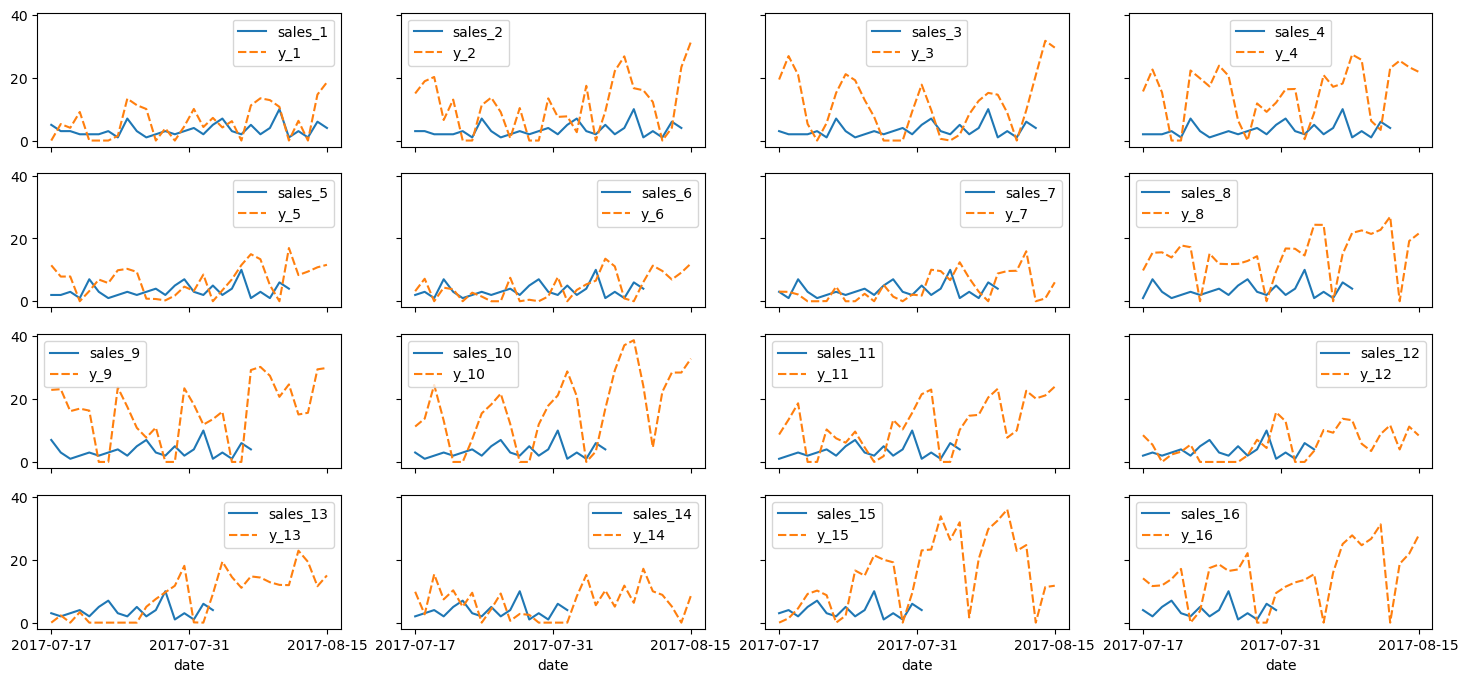

In [50]:
fig, axes = plt.subplots(4,4, figsize = (18,8), sharex=True, sharey=True)
for n in range(16):
    sns.lineplot(holdout.loc[(holdout.store_nbr == 1) &\
             (holdout.family == 'BEAUTY'), [f'sales_{n+1}', f'y_{n+1}']], ax = axes[n//4][n%4])
plt.xticks(pd.date_range(holdout.index[0], holdout.index[-1], 3))
plt.show()

In [55]:
subm = pd.read_csv('input_data/sample_submission.csv', index_col=0)

In [59]:
a = pd.DataFrame()
for i in range(16):
    a = pd.concat([a, final.loc[:, f'y_{i+1}']])

In [61]:
subm['sales'] = a[0].values

In [63]:
subm.to_csv('first_attempt.csv')

## Same, but add variance standartization step

In [50]:
#lags and MA features
ma_f = ['y_lag_1', 'y_lag_2', 'y_lag_3',
       'MA_2', 'MA_3', 'MA_4', 'MA_5', 'MA_6', 'MA_30', 'MA_60', 'MA_90']

In [51]:
#Variance normalization
for ds intrain.loc[:, ma_f]

,y_lag_1,y_lag_2,y_lag_3,MA_2,MA_3,MA_4,MA_5,MA_6,MA_30,MA_60,MA_90
date,,,,,,,,,,,
2013-05-01,1.000,0.000,0.000,0.500000,0.333333,0.500000,1.000000,1.166667,2.200000,2.050000,1.811111
2013-05-01,0.000,2.000,0.000,1.000000,0.666667,0.500000,0.600000,0.666667,1.700000,1.683333,1.688889
2013-05-01,1106.000,722.000,447.000,914.000000,758.333333,821.750000,847.800000,856.166667,884.233333,869.600000,836.644444
2013-05-01,330.655,270.019,175.662,300.337006,258.778671,256.542751,297.996402,289.586502,291.871667,277.843335,273.211690
2013-05-01,604.000,549.000,221.000,576.500000,458.000000,486.000000,598.200000,615.666667,630.000000,609.633333,603.877778
...,...,...,...,...,...,...,...,...,...,...,...
2017-05-31,8.000,8.000,14.000,8.000000,10.000000,10.250000,10.000000,10.000000,11.666667,13.766667,13.800000
2017-05-31,249.750,323.468,602.673,286.608994,391.963654,429.317741,450.094794,418.741664,437.401972,439.103736,438.167890
2017-05-31,124.241,109.639,141.130,116.939999,125.003334,127.439501,135.935402,131.772335,125.072733,123.479900,127.757967


In [38]:
params = {
          'iterations': 4000,
          'l2_leaf_reg': 5.0,
          'task_type': 'CPU',
          'verbose': 200,
          'border_count': 100,
          'cat_features': discrete_features,
          'thread_count': -1
    }

In [39]:
mask_holdout = holdout.sku.isin(sku_1)
mask_final = final.sku.isin(sku_1)

In [40]:
from tqdm.notebook import trange, tqdm

In [41]:
for seed in trange(len(y_cols)):
    cat = CatBoostRegressor(**params, random_state = seed+34)
    cat.fit(train.loc['2016':, x_cols], train.loc['2016':, y_cols[seed]],
           eval_set=(test.loc[test.loc[:, y_cols[seed]].notna(), x_cols],
                     test.loc[test.loc[:, y_cols[seed]].notna(), y_cols[seed]]),
            early_stopping_rounds=200,
            use_best_model=True)
    holdout[f'y_{seed+1}'] = 0
    holdout.loc[~mask_holdout, f'y_{seed+1}'] = cat.predict(holdout.loc[~mask_holdout, x_cols])
    holdout[f'y_{seed+1}'] = holdout[f'y_{seed+1}'].clip(0.0)
    
    final[f'y_{seed+1}'] = 0
    final.loc[~mask_final, f'y_{seed+1}'] = cat.predict(final.loc[~mask_final, x_cols])
    final[f'y_{seed+1}'] = final[f'y_{seed+1}'].clip(0.0)

  0%|          | 0/16 [00:00<?, ?it/s]

0:	learn: 1288.0315690	test: 1343.7244732	best: 1343.7244732 (0)	total: 393ms	remaining: 26m 13s
200:	learn: 285.9532780	test: 286.5322366	best: 286.5322366 (200)	total: 1m 6s	remaining: 21m 5s
400:	learn: 245.2318620	test: 250.0318248	best: 250.0318248 (400)	total: 2m 28s	remaining: 22m 9s
600:	learn: 225.7993575	test: 236.8998959	best: 236.8998959 (600)	total: 3m 49s	remaining: 21m 40s
800:	learn: 214.0945924	test: 228.9750131	best: 228.9750131 (800)	total: 5m 4s	remaining: 20m 16s
1000:	learn: 204.5354989	test: 222.6296175	best: 222.6296175 (1000)	total: 6m 19s	remaining: 18m 56s
1200:	learn: 197.7307324	test: 218.7127655	best: 218.7123381 (1197)	total: 7m 32s	remaining: 17m 34s
1400:	learn: 191.2972385	test: 217.5651457	best: 217.4219701 (1338)	total: 8m 46s	remaining: 16m 17s
1600:	learn: 185.7081185	test: 216.2482066	best: 216.2173176 (1598)	total: 10m 7s	remaining: 15m 9s
1800:	learn: 181.0940360	test: 214.2141465	best: 214.2141465 (1800)	total: 11m 21s	remaining: 13m 52s
2000:	

In [42]:
results = pd.DataFrame(columns=range(1,17))
for n in range(len(y_cols)):
    mask2 = holdout.loc[:, y_cols[n]].notna()
    results.loc[1, n+1] = mean_absolute_error(
            holdout.loc[mask2, y_cols[n]],
            holdout.loc[mask2, f'y_{n+1}'])

KeyError: 'y_2'

In [ ]:
results

#### Example for highrunners

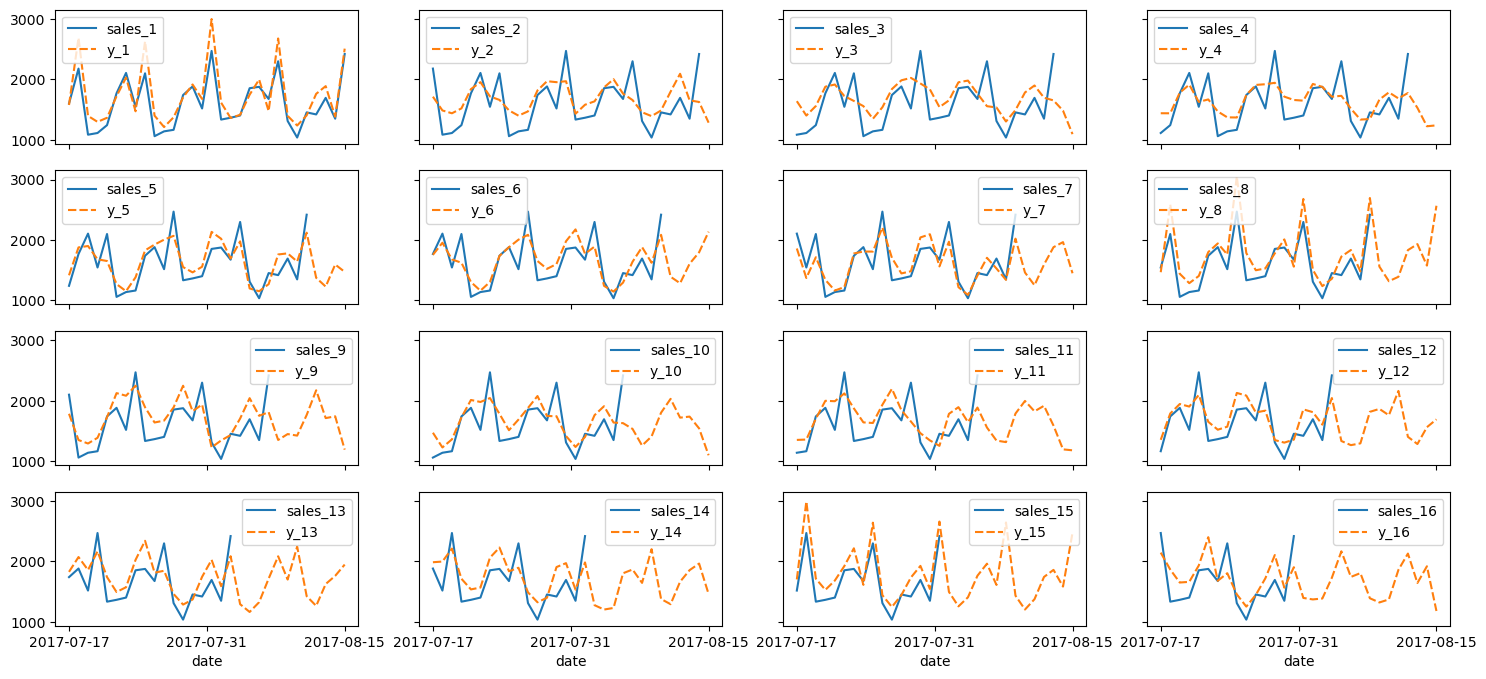

In [46]:
fig, axes = plt.subplots(4,4, figsize = (18,8), sharex=True, sharey=True)
for n in range(16):
    sns.lineplot(holdout.loc[(holdout.store_nbr == 9) &\
             (holdout.family == 'PRODUCE'), [f'sales_{n+1}', f'y_{n+1}']], ax = axes[n//4][n%4])
plt.xticks(pd.date_range(holdout.index[0], holdout.index[-1], 3))
plt.show()

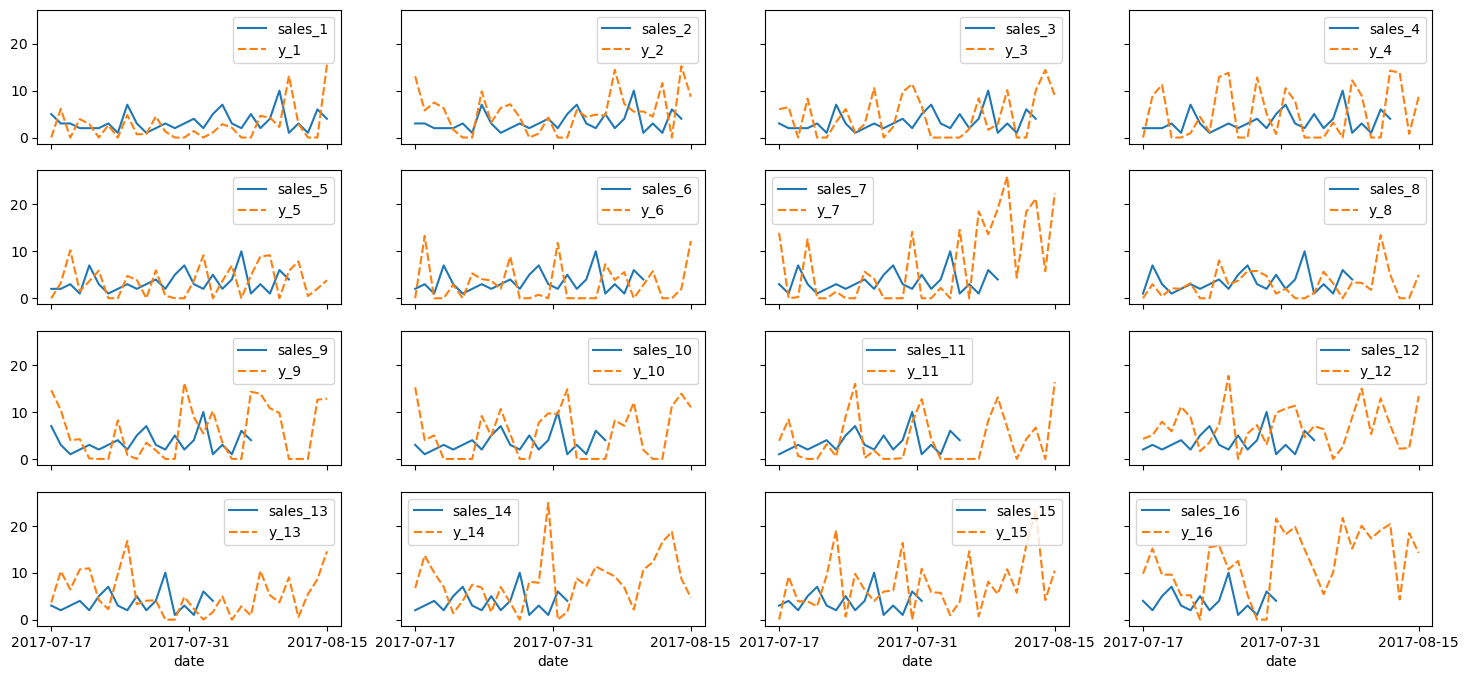

In [47]:
fig, axes = plt.subplots(4,4, figsize = (18,8), sharex=True, sharey=True)
for n in range(16):
    sns.lineplot(holdout.loc[(holdout.store_nbr == 1) &\
             (holdout.family == 'BEAUTY'), [f'sales_{n+1}', f'y_{n+1}']], ax = axes[n//4][n%4])
plt.xticks(pd.date_range(holdout.index[0], holdout.index[-1], 3))
plt.show()

In [99]:
import shap

In [100]:
explainer = shap.TreeExplainer(cat)

In [ ]:
shap_values = explainer.shap_values(train.loc[:, x_cols])

In [ ]:
shap.summary_plot(shap_values, train.loc[:, x_cols])

In [ ]:
shap_value = explainer.shap_values(test.loc[(test.store_nbr == 9) &\
             (test.family == 'PRODUCE'), x_cols])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_value, x_cols)